# Example LFPy
Example utilizing the  **`LFPykit`** module for predictions of
current dipole moment from a dendritic stick model set up in LFPy (https://LFPy.readthedocs.io, https://github.com/LFPy/LFPy).
The passive stick receives sinusoid synaptic current input at its terminal
segment.

Equivalent simulations set up using **NEURON** and **Arbor** are provided in `Example_NEURON.ipynb` and `Example_Arbor.ipynb`, respectively.

In [1]:
%matplotlib inline

In [2]:
## LFPy may be installed using pip:
#!pip install git+https://github.com/LFPy/LFPy.git

In [3]:
# compile sinsyn.mod file using nrnivmodl script
!nrnivmodl

/usr/bin/xcrun
/Users/espenhagen/Repositories/LFPykit/examples
Mod files: "./sinsyn.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
ld: warning: object file (./sinsyn.o) was built for newer macOS version (11.2) than being linked (11.0)
Successfully created arm64/special


In [4]:
# import modules
import numpy as np
import neuron
import LFPy
import lfpykit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [5]:
###############################################################################
# Define SectionList that can be fed into LFPy.Cell
###############################################################################
morphology = neuron.h.SectionList()
sec = neuron.h.Section(name='cell')

# specify geometry [um]
neuron.h.pt3dadd(neuron.h.Vector([0, 0]),    # x
                 neuron.h.Vector([0, 0]),    # y
                 neuron.h.Vector([0, 200]),  # z
                 neuron.h.Vector([2, 2]),    # diam
                 sec=sec)

# passive parameters and spatial discretization
sec.nseg = 41           # number of segments
sec.insert('pas')       # insert passive mechanism
for seg in sec:
    seg.pas.g = 0.0001  # passive resistivity [S/cm2]
    seg.pas.e = -65     # leak reversal potential [mV]
morphology.append(sec)

1.0

In [6]:
###############################################################################
# Create LFPy.Cell object
###############################################################################
cell = LFPy.Cell(morphology=morphology,
                      passive=False,
                      cm=1.,     # membrane capacitance [uF/cm2]
                      Ra=1000.,  # cytoplasmic resistivity [ohm cm]
                      v_init=-65.,  # initial voltage [mV]
                      nsegs_method=None,
                      delete_sections=False,
                      tstop=500.,  # simulation duration [ms]
                      )
# position cell so zstart[0] = 0 (similar to example_NEURON.ipynb)
cell.set_pos(0, 0, cell.length[0] / 2)
stim = LFPy.StimIntElectrode(cell, idx=cell.totnsegs - 1,
                             pptype='SinSyn')

In [7]:
###############################################################################
# Create forward model object and get linear response matrix
###############################################################################
cdm = lfpykit.CurrentDipoleMoment(cell=cell)
M = cdm.get_transformation_matrix()

In [8]:
###############################################################################
# run simulation, compute measurement
###############################################################################
cell.simulate(variable_dt=True,
                   probes=[cdm],
                   rec_imem=True,
                   rec_vmem=True)
# current dipole moment
P = cdm.data

# copy some output to GeometryCell for plotting
cell.time = cell.tvec
cell.V_m = cell.vmem
cell.I_m = cell.imem

In [9]:
###############################################################################
# check that output is identical to dipole moment computed using recorded
# membrane currents
###############################################################################
try:
    np.testing.assert_allclose(P, M @ cell.I_m)
except AssertionError as ae:
    raise ae('not so useful error message')

In [10]:
###############################################################################
# plot
###############################################################################
def colorbar(fig, ax, im,
             width=0.01,
             height=1.0,
             hoffset=0.01,
             voffset=0.0,
             orientation='vertical'):
    '''
    draw colorbar without resizing the axes object to make room
    '''
    rect = np.array(ax.get_position().bounds)
    rect = np.array(ax.get_position().bounds)
    caxrect = [0] * 4
    caxrect[0] = rect[0] + rect[2] + hoffset * rect[2]
    caxrect[1] = rect[1] + voffset * rect[3]
    caxrect[2] = rect[2] * width
    caxrect[3] = rect[3] * height
    cax = fig.add_axes(caxrect)
    cb = fig.colorbar(im, cax=cax, orientation=orientation)
    return cb

Text(0.5, 0, '$t$ (ms)')

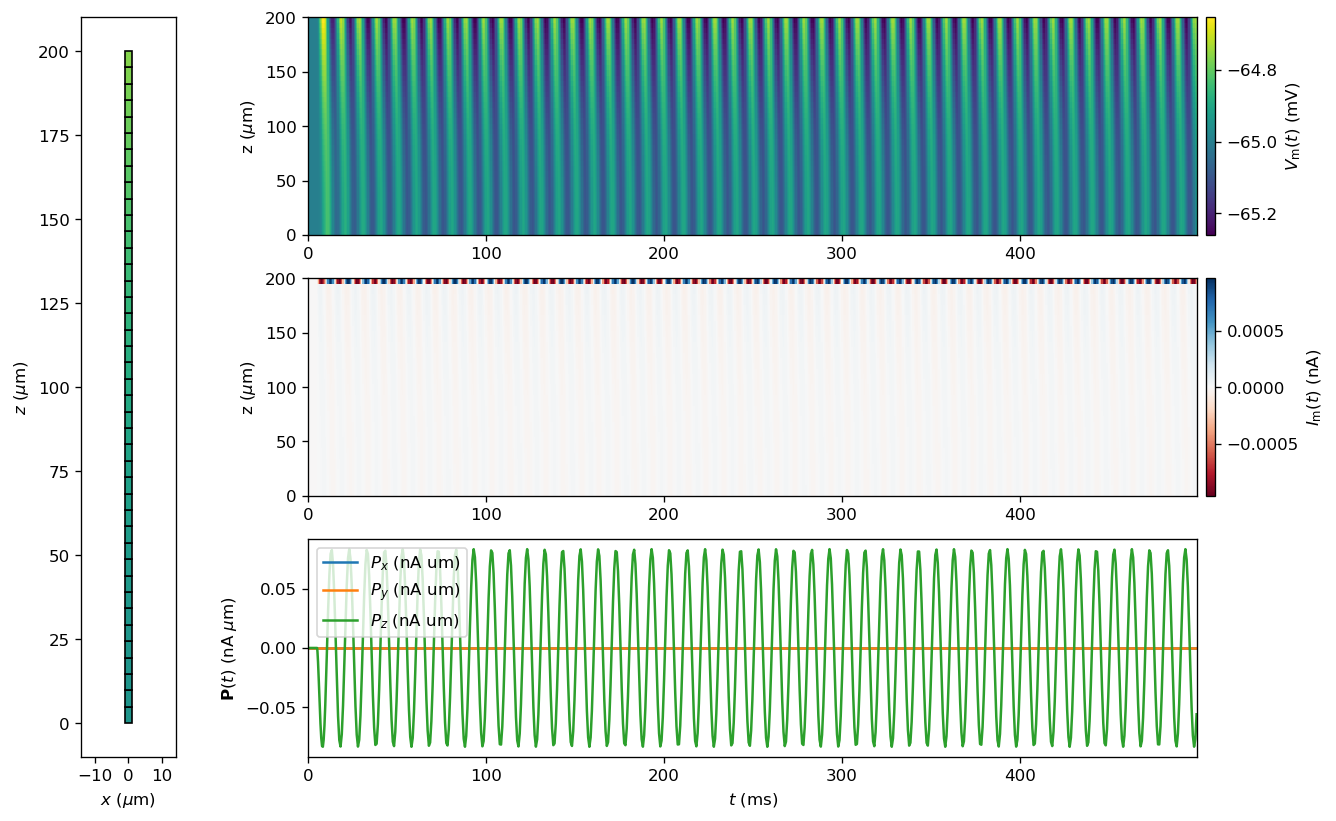

In [11]:
fig = plt.figure(figsize=(12, 8), dpi=120)
gs = GridSpec(3, 10)
# morphology
ax0 = fig.add_subplot(gs[:, 0])
norm = plt.Normalize(vmin=cell.V_m.min(), vmax=cell.V_m.max())
for z, d, v in zip(cell.z, cell.d, cell.V_m[:, -1]):
    ax0.add_patch(plt.Rectangle((-d / 2, z[0]), d, z[1] - z[0],
                                ec='k', fc=plt.cm.viridis(norm(v))))
ax0.axis(ax0.axis('equal'))
ax0.set_xlabel(r'$x$ ($\mu$m)')
ax0.set_ylabel(r'$z$ ($\mu$m)')

# membrane voltage
ax1 = fig.add_subplot(gs[0, 2:])
im1 = ax1.pcolormesh(cell.time, cell.z.mean(axis=-1), cell.V_m,
                     shading='auto', norm=norm)
ax1.set_ylabel(r'z ($\mu$m)')
cb = colorbar(fig, ax1, im1)
cb.set_label(r'$V_\mathrm{m}(t)$ (mV)')

# membrane current
ax2 = fig.add_subplot(gs[1, 2:], sharex=ax1, sharey=ax1)
im2 = ax2.pcolormesh(cell.time, cell.z.mean(axis=-1), cell.I_m,
                     cmap='RdBu', shading='auto')
ax2.set_ylabel(r'z ($\mu$m)')
cb = colorbar(fig, ax2, im2)
cb.set_label(r'$I_\mathrm{m}(t)$ (nA)')

# current dipole moment
ax3 = fig.add_subplot(gs[2, 2:], sharex=ax1)
ax3.plot(cell.time, P.T)
ax3.legend([r'$P_x$ (nA um)', r'$P_y$ (nA um)', r'$P_z$ (nA um)'])
ax3.set_ylabel(r'$\mathbf{P}(t)$ (nA $\mu$m)')
ax3.set_xlabel('$t$ (ms)')